## Домашка

### Задание 1 (8 баллов)
Обучите модель с минимум 15 слоями, где у каждого слоя разные параметры (Dropout, Conv1d и Pooling, Dense считаются слоями, остальное нет, но их тоже можно использовать). Как минимум 4 слоя должны быть наложены друг на друга и как минимум 2 параллельных слоя (последовательности слоев). Должен быть хотя бы один слой каждого типа.

При обучении используйте колбек для отслеживания лучшей модели. Ориентируйтесь на Recall@Precision меру. Качество модели не должно быть околонулевым. Если метрики не растут, то попробуйте пообучать подольше или перестроить саму сеть.

Советы: Начните с небольших сетей и постепенно добавляйте, не пытайтесь сразу собрать все слои. Иногда кернел может крашиться просто так или из-за слишком больших матриц.

In [24]:
import os
os.environ["KERAS_BACKEND"] = "torch"

In [25]:
import keras
print(keras.__version__)

3.8.0


In [26]:
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
data = pd.read_csv('lenta_40k.csv.zip')

In [28]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [29]:
# словарь
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [30]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [31]:
# индексируем слова
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [32]:
id2word = {i:word for word, i in word2id.items()}

In [33]:
# переводим тексты в последовательности индексов
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [34]:
MAX_LEN = max(len(x) for x in X)

In [35]:
MEAN_LEN = np.median([len(x) for x in X])

In [36]:
MAX_LEN, int(MEAN_LEN)

(1748, 170)

In [37]:
MAX_LEN = int(MEAN_LEN + 30)

In [38]:
# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [39]:
X.shape

(44356, 200)

In [40]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [41]:
y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [42]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42)

In [43]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла
                                                monitor='val_rec@prec', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается
early_stop = keras.callbacks.EarlyStopping(monitor='val_rec@prec',
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=5, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode='max',
                                              )

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))

embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)


# параллельные сверточные слои:
conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(embeddings)
conv2 = keras.layers.Conv1D(filters=64, kernel_size=5, activation='relu', padding='same')(embeddings)
conv3 = keras.layers.Conv1D(filters=64, kernel_size=7, activation='relu', padding='same')(embeddings)

concat1 = keras.layers.concatenate([conv1, conv2, conv3])  # объединяем

drop1 = keras.layers.Dropout(0.5)(concat1)


# еще параллельные + наложенные слои:
convs = []

for ks, filter in [(3, 32), (4, 48), (5, 64), (7, 80), (10, 96)]:
    conv4 = keras.layers.Conv1D(kernel_size=ks, filters=filter, padding='same', strides=1)(drop1)
    conv5 = keras.layers.Conv1D(kernel_size=ks, filters=filter, padding='same', strides=1, activation='relu', kernel_regularizer='l2')(conv4)
    conv6 = keras.layers.ZeroPadding1D(padding=1)(conv5)
    conv7 = keras.layers.MaxPooling1D(pool_size=2)(conv6)
    convs.append(conv7)

concat = keras.layers.concatenate(convs, axis=2)
drop2 = keras.layers.Dropout(0.3)(concat)


conv8 = keras.layers.Conv1D(kernel_size=5, filters=256, padding='same', activation='relu')(drop2)
conv9 = keras.layers.MaxPooling1D(pool_size=2)(conv8)
drop3 = keras.layers.Dropout(0.4)(conv9)


flatten = keras.layers.Flatten()(drop3)
dense = keras.layers.Dense(units=50, activation='relu')(flatten)
drop4 = keras.layers.Dropout(0.5)(dense)

dense2 = keras.layers.Dense(units=128, activation='relu')(drop4)
outputs = keras.layers.Dense(units=len(label2id), activation='softmax')(dense2)



model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')],
              )

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=100,
         callbacks=[checkpoint, early_stop])

/usr/local/lib/python3.11/dist-packages/keras/src/backend/torch/nn.py:466: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at ../aten/src/ATen/native/Convolution.cpp:1036.)
  outputs = tnn.conv1d(


Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - loss: 2.8401 - rec@prec: 0.0000e+00
Epoch 1: val_rec@prec improved from -inf to 0.00000, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 884ms/step - loss: 2.8207 - rec@prec: 0.0000e+00 - val_loss: 1.4862 - val_rec@prec: 0.0000e+00
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 849ms/step - loss: 1.2431 - rec@prec: 1.1246e-04
Epoch 2: val_rec@prec did not improve from 0.00000
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 863ms/step - loss: 1.2350 - rec@prec: 1.1170e-04 - val_loss: 0.6945 - val_rec@prec: 0.0000e+00
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 841ms/step - loss: 0.5984 - rec@prec: 1.1597e-04
Epoch 3: val_rec@prec did not improve from 0.00000
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 855ms/step - loss: 0.5954 - rec@prec: 1.1196e-04 - val_loss: 0.3902 - val_rec@prec: 0.0000e+00
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 826ms/step - loss: 0.3480 - rec@prec: 1.5165e-04
Epoch 4: val_rec@prec improved from 0.00000 to 0.06177, saving model t

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


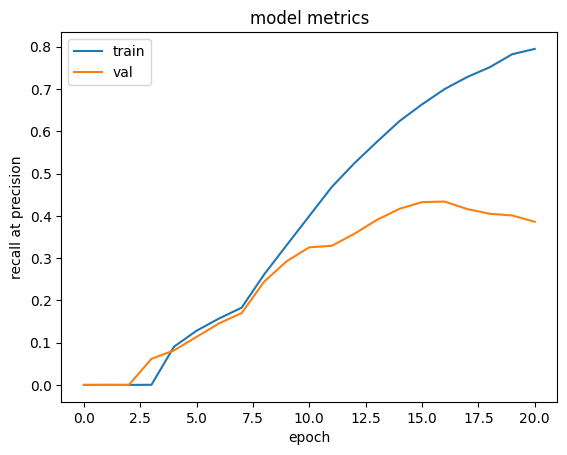

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### Задание 2 (2 балла)
Обучите нейросеть со сверточными слоями с архитектурой похожей на Unet - https://en.wikipedia.org/wiki/U-Net

Не нужно воспроизводить все в точности, главное, чтобы было сокращение длины последовательности с помощью CNN, а затем обратное увеличение длины последовательности до изначальной с residual связями между промежуточными шагами с одинаковыми размерностями.
Изменений размерности должно быть хотя бы 3 и соответственно residual связей тоже.

Для повышения размерности используйте keras.layers.UpSampling1D
Полученная модель должна давать ненулевое качество на той же самой задаче классификации текстов.

In [49]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint_unet = keras.callbacks.ModelCheckpoint('model.weights.h5', # названия файла
                                                monitor='val_rec@prec', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается
early_stop_unet = keras.callbacks.EarlyStopping(monitor='val_rec@prec',
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1,
                                              mode='max',
                                              )

In [50]:
# inputs layer
inputs_unet = keras.layers.Input(shape=(MAX_LEN,))
embeddings_unet = keras.layers.Embedding(input_dim=len(word2id), output_dim=128, input_length=MAX_LEN)(inputs_unet)


# contracting path (encoder)
conv_unet_1 = keras.layers.Conv1D(kernel_size=3, filters=64, padding='same', activation='relu')(embeddings_unet)
conv_unet_1 = keras.layers.Conv1D(kernel_size=3, filters=64, padding='same', activation='relu')(conv_unet_1)
conv_unet_1_pooling = keras.layers.MaxPooling1D(pool_size=2)(conv_unet_1)

conv_unet_2 = keras.layers.Conv1D(kernel_size=3, filters=128, padding='same', activation='relu')(conv_unet_1_pooling)
conv_unet_2 = keras.layers.Conv1D(kernel_size=3, filters=128, padding='same', activation='relu')(conv_unet_2)
conv_unet_2_pooling = keras.layers.MaxPooling1D(pool_size=2)(conv_unet_2)

conv_unet_3 = keras.layers.Conv1D(kernel_size=3, filters=256, padding='same', activation='relu')(conv_unet_2_pooling)
conv_unet_3 = keras.layers.Conv1D(kernel_size=3, filters=256, padding='same', activation='relu')(conv_unet_3)
conv_unet_3_pooling = keras.layers.MaxPooling1D(pool_size=2)(conv_unet_3)


# bottleneck
conv_unet_bottleneck = keras.layers.Conv1D(kernel_size=3, filters=512, padding='same', activation='relu')(conv_unet_3_pooling)
conv_unet_bottleneck = keras.layers.Conv1D(kernel_size=3, filters=512, padding='same', activation='relu')(conv_unet_bottleneck)


# expansive path (decoder)
conv_unet_upsampling_1 = keras.layers.UpSampling1D(size=2)(conv_unet_bottleneck)
concat_unet_1 = keras.layers.Concatenate()([conv_unet_upsampling_1, conv_unet_3])
conv_unet_4 = keras.layers.Conv1D(kernel_size=3, filters=256, padding='same', activation='relu')(concat_unet_1)
conv_unet_4 = keras.layers.Conv1D(kernel_size=3, filters=256, padding='same', activation='relu')(conv_unet_4)

conv_unet_upsampling_2 = keras.layers.UpSampling1D(size=2)(conv_unet_4)
concat_unet_2 = keras.layers.Concatenate()([conv_unet_upsampling_2, conv_unet_2])
conv_unet_5 = keras.layers.Conv1D(kernel_size=3, filters=128, padding='same', activation='relu')(concat_unet_2)
conv_unet_5 = keras.layers.Conv1D(kernel_size=3, filters=128, padding='same', activation='relu')(conv_unet_5)

conv_unet_upsampling_3 = keras.layers.UpSampling1D(size=2)(conv_unet_5)
concat_unet_3 = keras.layers.Concatenate()([conv_unet_upsampling_3, conv_unet_1])
conv_unet_6 = keras.layers.Conv1D(kernel_size=3, filters=64, padding='same', activation='relu')(concat_unet_3)
conv_unet_6 = keras.layers.Conv1D(kernel_size=3, filters=64, padding='same', activation='relu')(conv_unet_6)

# outputs layer
flatten_unet = keras.layers.Flatten()(conv_unet_6)

outputs_unet = keras.layers.Dense(units=len(label2id), activation='softmax')(flatten_unet)



model_unet = keras.Model(inputs=inputs_unet, outputs=outputs_unet)
optimizer_unet = keras.optimizers.Adam(learning_rate=0.001)
model_unet.compile(optimizer=optimizer_unet,
              loss='categorical_crossentropy',
              metrics=[keras.metrics.RecallAtPrecision(0.8, name='rec@prec')],
              )

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [51]:
model_unet.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=2000,
         epochs=100,
         callbacks=[checkpoint_unet, early_stop_unet])

Epoch 1/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 813ms/step - loss: 2.5698 - rec@prec: 0.0000e+00
Epoch 1: val_rec@prec improved from -inf to 0.00000, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 835ms/step - loss: 2.5630 - rec@prec: 0.0000e+00 - val_loss: 2.3001 - val_rec@prec: 0.0000e+00
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 832ms/step - loss: 2.1588 - rec@prec: 8.7270e-05
Epoch 2: val_rec@prec improved from 0.00000 to 0.00541, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 862ms/step - loss: 2.1546 - rec@prec: 9.6889e-05 - val_loss: 1.9285 - val_rec@prec: 0.0054
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 854ms/step - loss: 1.7762 - rec@prec: 0.0036
Epoch 3: val_rec@prec improved from 0.00541 to 0.12128, saving model to model.weights.h5
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 879ms/step - loss: 1.7734 - rec@prec: 0.0043 - val_loss: 1.6224 - val_rec@prec: 0.1213
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 830ms/step - loss: 1.3883 - rec@prec: 0.1723
Epoch 4: val_r

dict_keys(['loss', 'rec@prec', 'val_loss', 'val_rec@prec'])


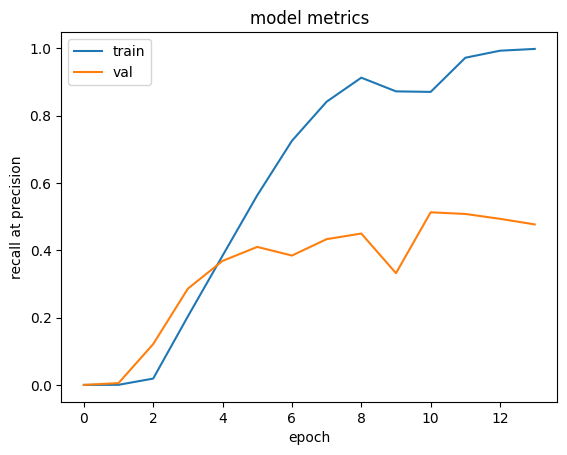

In [52]:
print(model_unet.history.history.keys())
# summarize history for accuracy
plt.plot(model_unet.history.history['rec@prec'])
plt.plot(model_unet.history.history['val_rec@prec'])
plt.title('model metrics')
plt.ylabel('recall at precision')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()